In [1]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
df = pd.read_csv("Book1.csv")

# Checking if # of observations is correct
df.tail()

,text,label
39994,Having projects over Break is never fun LUT wh...,0
39995,Do you think that Venus is worth exploring? We...,0
39996,Facial Action Coding System (FACS) would be an...,0
39997,Have you ever asked for advice?\n\nI'o sure th...,0
39998,"Dear Principal,\n\nWanting to help your commun...",0


In [10]:
# Count AI-generated and human-written essays
ai_count = (df['label'] == 1).sum()  # AI essays are labeled as 0
human_count = (df['label'] == 0).sum()  # Human essays are labeled as 1
total_count = len(df)

# Compute percentages
x_percent = (ai_count / total_count) * 100
y_percent = (human_count / total_count) * 100

# Calculate essay length statistics
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))  # Count words in each essay

z_avg_length = df['word_count'].mean()
a_min_length = df['word_count'].min()
b_max_length = df['word_count'].max()

# Print results
print(f"Total number of essays: {total_count}")
print(f"Number of AI-generated essays: {ai_count} ({x_percent:.2f}%)")
print(f"Number of human-written essays: {human_count} ({y_percent:.2f}%)")
print(f"Average essay length: {z_avg_length:.2f} words")
print(f"Shortest essay length: {a_min_length} words")
print(f"Longest essay length: {b_max_length} words")

Total number of essays: 39999
Number of AI-generated essays: 14674 (36.69%)
Number of human-written essays: 25325 (63.31%)
Average essay length: 387.20 words
Shortest essay length: 42 words
Longest essay length: 1368 words


Text preprocessing using spaCy:

In [ ]:
df["text"] = df["text"].str.lower()

In [ ]:
df["text"] = df["text"].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

In [ ]:
import spacy


nlp = spacy.load("en_core_web_sm")

def preprocess_texts(texts):
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=50, disable=["ner", "parser"]):  # Disabling NER & parser for speed
        tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
        processed_texts.append(" ".join(tokens))
    return processed_texts

df["processed_text"] = preprocess_texts(df["text"])

In [ ]:
df.tail()

,text,label,processed_text
39994,having projects over break is never fun lut wh...,0,have project break fun lut choose project stud...
39995,do you think that venus is worth exploring wel...,0,think venus worth explore story challenge expl...
39996,facial action coding system facs would be an a...,0,facial action code system fac amazing classroo...
39997,have you ever asked for advice\n\nio sure that...,0,ask advice io sure everybody need second opini...
39998,dear principal\n\nwanting to help your communi...,0,dear principal want help community great thing...


Here, I am attempting topic modelling using LDA/TF-IDF.

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
text_tfidf = vectorizer.fit_transform(df["processed_text"])

In [ ]:
# fitting LDA model with 6 topics
num_topics = 6
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
topic_distribution = lda_model.fit_transform(text_tfidf)

In [ ]:
# assigning each essay a topic based on the LDA results
df["lda_topic"] = topic_distribution.argmax(axis=1)

In [ ]:
df.tail()

,text,label,processed_text,topic,lda_topic
39994,having projects over break is never fun lut wh...,0,have project break fun lut choose project stud...,Education,3
39995,do you think that venus is worth exploring wel...,0,think venus worth explore story challenge expl...,Space Exploration,0
39996,facial action coding system facs would be an a...,0,facial action code system fac amazing classroo...,Education,1
39997,have you ever asked for advice\n\nio sure that...,0,ask advice io sure everybody need second opini...,Motivation,1
39998,dear principal\n\nwanting to help your communi...,0,dear principal want help community great thing...,Education,3


Here, I am assigning custom topics using keyword mapping because solely using LDA was sometimes putting words into the wrong category, and impacting my visualization.

In [ ]:
topic_keywords = {
    "Politics": ["government", "policy", "election", "electoral", "senator", "vote", "president", "congress"],
    "Space Exploration": ["nasa", "moon", "mars", "spaceship", "astronaut", "venus", "spacecraft"],
    "Education": ["student", "school", "subjects" "college", "university", "learning", "teacher", "classroom", "extracurricular"],
    "Automotive Vehicles": ["car", "driverless", "engine", "road", "fuel", "driving", "highway", "transport"],
    "Motivation": ["success", "goal", "achievement", "work hard" "failure", "positive", "dream", "inspire"],
    "Technology": ["smartphone", "online", "cloud", "software", "computer", "digital", "communication", "cell phone" "internet"]
}

def assign_topic(text):
    for topic, keywords in topic_keywords.items():
        if any(word in text for word in keywords):
            return topic
    return None  # Default to None if no match

df["topic"] = df["processed_text"].apply(assign_topic)

# if LDA didn't find a topic, use the assigned one -- minimizing chances of error
df["topic"] = df["topic"].fillna(df["lda_topic"].map({
    0: "Politics",
    1: "Space Exploration",
    2: "Education",
    3: "Automotive Vehicles",
    4: "Motivation",
    5: "Technology"
}))

Now, I'm categorizing AI versus Human essays.

In [ ]:
df["Category"] = df["label"].map({1: "AI", 0: "Human"})

Analyzing topic distribution by AI versus Human essays.

In [ ]:
topic_counts = df.groupby(["topic", "Category"]).size().unstack()
topic_counts.columns = ["Human", "AI"]

This is relevant for creating a dashboard for the visualizations later, since I won't be using the original csv file again.

In [ ]:
df.to_pickle("processed_texts.pkl")
print("Preprocessed dataframe saved successfully!")

Preprocessed dataframe saved successfully!


Visualizing the AI vs Human writing trends:

In [ ]:
import plotly.express as px
import pandas as pd

# using the actual dataset
df_counts = topic_counts.reset_index()
df_counts = df_counts.melt(id_vars=["topic"], var_name="Source", value_name="Count")

# creating an interactive bar chart
fig = px.bar(
    df_counts,
    x="topic",
    y="Count",
    color="Source",
    barmode="group",
    title="What Do Humans Write About vs. What They Use AI For?",
    labels={"Count": "Number of Essays", "topic": "Essay Topic"},
    color_discrete_map={"Human": "#70A494", "AI": "#E8998D"},  # Teal & Coral theme
    hover_data={"Count": ":,", "Source": True, "topic": False}
)


fig.update_layout(
    template="plotly_white",  # white background
    xaxis_tickangle=0,  # keeping x-axis labels horizontal
    title_x=0.5,
    bargap=0.2,  # adding spacing between bars for clarity
    font=dict(family="Lato, Arial, sans-serif", size=14),
    title_font=dict(size=20, family="Lato, Arial, sans-serif"),
    xaxis_title_font=dict(size=16),
    yaxis_title_font=dict(size=16),
    legend_title_text="Essay Origin",
    legend=dict(title_font_size=14)
)

# Improve bar appearance and interactivity
fig.update_traces(marker_line_width=1, marker_line_color="black", opacity=0.9, hoverinfo="x+y")

fig.show()


Tree map of the same data for an alternative visualization:

In [ ]:
import plotly.express as px
import numpy as np
import pandas as pd

# categorizing AI vs. Human
df["Category"] = df["label"].map({1: "AI", 0: "Human"})

# Aggregate counts per topic and category
topic_counts = df.groupby(["topic", "Category"]).size().reset_index(name="Count")

# calculate percentages to add to the viz
total_count = topic_counts["Count"].sum()
topic_counts["Percentage"] = (topic_counts["Count"] / total_count) * 100
topic_counts["PercentageLabel"] = topic_counts["Percentage"].round(1).astype(str) + "%"  # Only the percentage

# Compute the weighted midpoint for balanced coloring
color_midpoint = np.average(topic_counts["Count"], weights=topic_counts["Count"])

# Create treemap
fig = px.treemap(
    topic_counts,
    path=[px.Constant("All Topics"), "Category", "topic"],  # Single root node for clarity
    values="Count",
    color="Count",
    hover_data={"Count": True, "Percentage": True},
    color_continuous_scale="RdBu",  # Blue-Red scale like the example
    color_continuous_midpoint=color_midpoint,  # Balanced color gradient
)

# Update labels to show only the percentage (topic names are already included by default)
fig.update_traces(textinfo="label+text", text=topic_counts["PercentageLabel"])

fig.update_layout(
    margin=dict(t=50, l=25, r=25, b=25),
    title="What Do Humans Write About vs. What They Use AI For?",
    title_x=0.5,
    title_font=dict(size=24, family="Lato, Arial, sans-serif", color="white"),  # large & modern font
    paper_bgcolor="black",
    font=dict(family="Lato, Arial, sans-serif", size=16, color="white"),
)

fig.update_traces(
    textfont=dict(size=14, family="Lato, Arial, sans-serif"),  # Make labels more readable
)


fig.show()


Depicting word clouds per topic:

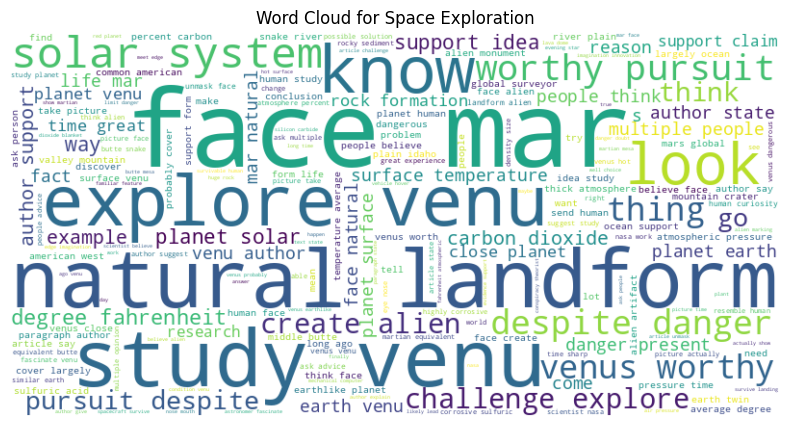

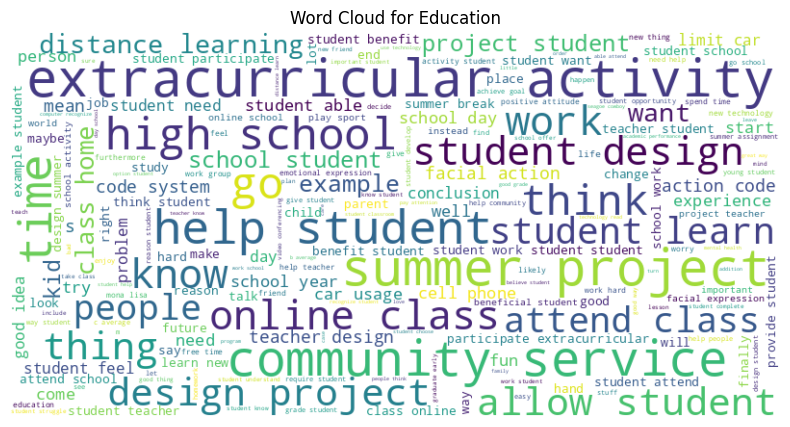

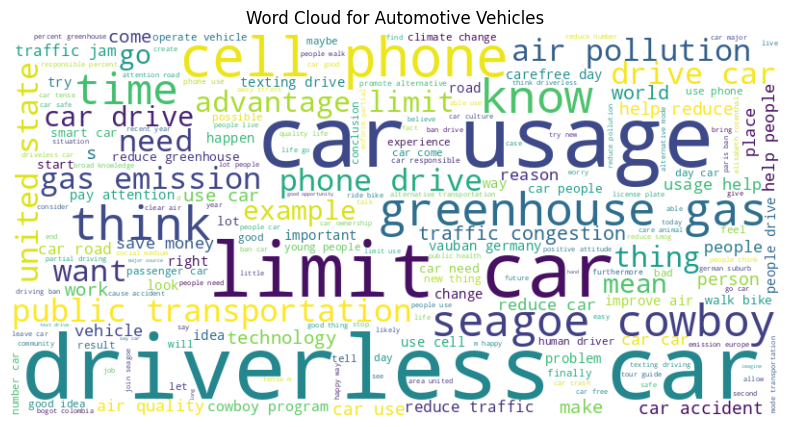

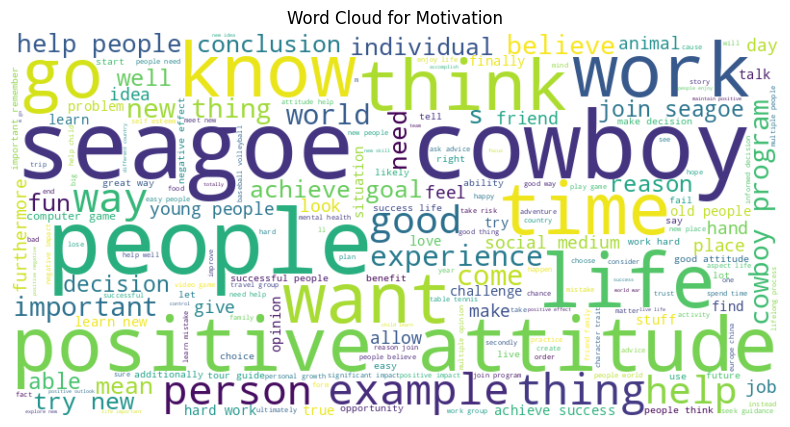

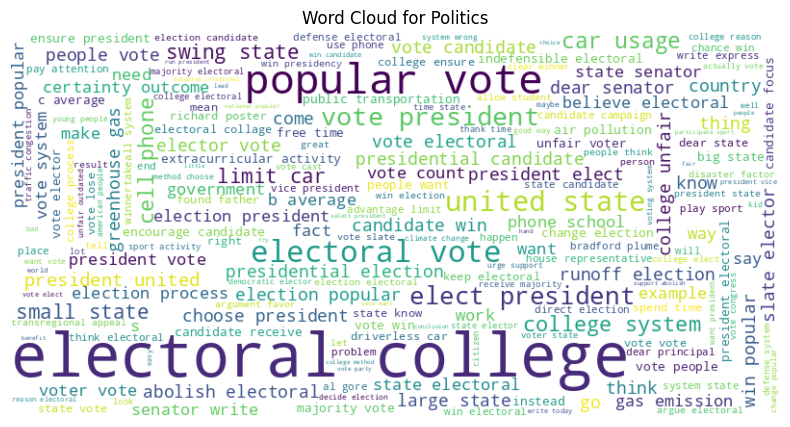

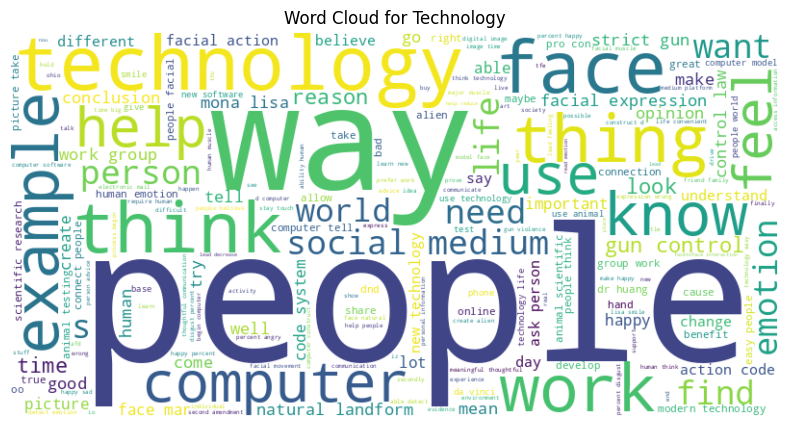

In [ ]:
for topic in df["topic"].unique():
    topic_text = " ".join(df[df["topic"] == topic]["processed_text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(topic_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {topic}")
    plt.show()

This code is to generate a horizontal bar graph that visually compares word frequency differences between AI-generated and human-written essays:

In [ ]:
# Convert labels (1 = AI, 0 = Human)
ai_texts = " ".join(df[df["label"] == 1]["processed_text"])
human_texts = " ".join(df[df["label"] == 0]["processed_text"])

# Get word frequencies
ai_word_freq = Counter(ai_texts.split())
human_word_freq = Counter(human_texts.split())

# choosing meaningful words
key_words = [
    "opinion", "feel", "experience", "understand", "believe",
    "analysis", "findings", "research", "therefore", "hypothesis",
    "perspective", "evidence", "interpret", "hope",
    "conclusion", "fact", "objective", "significant"
]

In [ ]:
# Create DataFrame with selected words
word_freq_df = pd.DataFrame({
    "word": key_words,
    "ai_freq": [ai_word_freq.get(word, 0) for word in key_words],
    "human_freq": [human_word_freq.get(word, 0) for word in key_words]
})

# Word frequency difference calculation
word_freq_df["freq_diff"] = word_freq_df["human_freq"] - word_freq_df["ai_freq"]

# Remove zero-frequency words (prevents empty graph)
word_freq_df = word_freq_df[(word_freq_df["ai_freq"] > 0) | (word_freq_df["human_freq"] > 0)]

# Debug: Check final dataset
print("Final word frequency table:\n", word_freq_df)

# Check if data exists for visualization
if word_freq_df.empty:
    raise ValueError("No words found in both AI and Human texts! Try different word selections.")

# Sort words for better visualization
word_freq_df = word_freq_df.sort_values(by="freq_diff", ascending=True)


Final word frequency table:
            word  ai_freq  human_freq  freq_diff
0       opinion     3221        9672       6451
1          feel     5000       13064       8064
2    experience     6792        5769      -1023
3    understand     4288        6353       2065
4       believe    10068       11754       1686
5      analysis      348         138       -210
7      research     2339        2498        159
9    hypothesis       78          18        -60
10  perspective     2541         984      -1557
11     evidence     1909        2717        808
12    interpret      173         102        -71
13         hope      874        2390       1516
14   conclusion     8339        5677      -2662
15         fact     1907        4971       3064
16    objective      278         135       -143
17  significant     3612         300      -3312


AI vs. Human Word Usage Difference Graph:

In [ ]:
import plotly.graph_objects as go

# capitalizing words for aesthetic reasons
word_freq_df["word"] = word_freq_df["word"].str.title()

# Separate AI-preferred and Human-preferred words
human_words = word_freq_df[word_freq_df["freq_diff"] > 0]
ai_words = word_freq_df[word_freq_df["freq_diff"] < 0]

fig = go.Figure()

# Add Human words
fig.add_trace(go.Bar(
    x=human_words["freq_diff"],
    y=human_words["word"],
    orientation="h",
    marker=dict(color="red"),
    name="More Common in Human Essays",
    visible=True
))

# Add AI words
fig.add_trace(go.Bar(
    x=ai_words["freq_diff"],
    y=ai_words["word"],
    orientation="h",
    marker=dict(color="blue"),
    name="More Common in AI Essays",
    visible=True
))

# updating layout with clearer axis title
fig.update_layout(
    title="<b>AI vs. Human Word Usage Difference</b>",
    xaxis_title="<b>Frequency Difference in Word Occurrence</b>",
    yaxis_title="<b>Word</b>",
    coloraxis_showscale=False
)

fig.show()


Creating a dashboard for this project:

In [ ]:
! pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html
from wordcloud import WordCloud
import base64
from io import BytesIO
from collections import Counter
import plotly.graph_objects as go
import numpy as np

# load processed data, not original csv file
df = pd.read_pickle("processed_texts.pkl")
df["Category"] = df["label"].map({1: "AI", 0: "Human"})

# ensure 'topic' column exists: pervasive issue
if "topic" not in df.columns:
    print("Reapplying topic assignment...")

    topic_keywords = {
        "Politics": ["government", "policy", "election", "electoral", "senator", "vote", "president", "congress"],
        "Space Exploration": ["nasa", "moon", "mars", "spaceship", "astronaut", "venus", "spacecraft"],
        "Education": ["student", "school", "subjects", "college", "university", "learning", "teacher", "classroom", "extracurricular"],
        "Automotive Vehicles": ["car", "driverless", "engine", "road", "fuel", "driving", "highway", "transport"],
        "Motivation": ["success", "goal", "achievement", "work hard", "failure", "positive", "dream", "inspire"],
        "Technology": ["smartphone", "online", "cloud", "software", "computer", "digital", "communication", "cell phone", "internet"]
    }

    def assign_topic(text):
        for topic, keywords in topic_keywords.items():
            if any(word in text for word in keywords):
                return topic
        return None

    df["topic"] = df["processed_text"].apply(assign_topic)

    df["topic"] = df["topic"].fillna(df["label"].map({
        0: "Politics",
        1: "Space Exploration",
        2: "Education",
        3: "Automotive Vehicles",
        4: "Motivation",
        5: "Technology"
    }))

# Topic distribution
topic_counts = df.groupby(["topic", "Category"]).size().reset_index(name="Count")

# Calculate percentages
total_count = topic_counts["Count"].sum()
topic_counts["Percentage"] = (topic_counts["Count"] / total_count) * 100
topic_counts["PercentageLabel"] = topic_counts["Percentage"].round(1).astype(str) + "%"

# Compute the weighted midpoint for balanced coloring
color_midpoint = np.average(topic_counts["Count"], weights=topic_counts["Count"])

# Generate topic-based word clouds
def generate_topic_wordcloud(topic):
    topic_text = " ".join(df[df["topic"] == topic]["processed_text"])
    wordcloud = WordCloud(width=1000, height=500, background_color="white").generate(topic_text)  # Increased size
    buf = BytesIO()
    wordcloud.to_image().save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

# Word frequency difference visualization
ai_texts = " ".join(df[df["Category"] == "AI"]["processed_text"])
human_texts = " ".join(df[df["Category"] == "Human"]["processed_text"])

ai_word_freq = Counter(ai_texts.split())
human_word_freq = Counter(human_texts.split())

# Generate word frequency difference data
## Define key words for word frequency difference visualization
key_words = [
    "opinion", "feel", "experience", "understand", "believe",
    "analysis", "findings", "research", "therefore", "hypothesis",
    "perspective", "evidence", "interpret", "hope",
    "conclusion", "fact", "objective", "significant"
]

# Generate word frequency difference data
word_freq_df = pd.DataFrame({
    "word": key_words,
    "ai_freq": [ai_word_freq.get(word, 0) for word in key_words],
    "human_freq": [human_word_freq.get(word, 0) for word in key_words]
})

# Ensure word column formatting
word_freq_df["word"] = word_freq_df["word"].str.title()
word_freq_df["freq_diff"] = word_freq_df["human_freq"] - word_freq_df["ai_freq"]
word_freq_df = word_freq_df[(word_freq_df["ai_freq"] > 0) | (word_freq_df["human_freq"] > 0)]
word_freq_df = word_freq_df.sort_values(by="freq_diff", ascending=True)



# Dash App
app = dash.Dash(__name__)

app.layout = html.Div(style={"fontFamily": "Arial, sans-serif", "padding": "20px", "backgroundColor": "#f8f9fa"}, children=[
    html.H1("AI vs. Human Writing Analysis", style={"textAlign": "center", "color": "#333", "fontSize": "32px"}),

    # First Bar Chart
    html.Div([
        html.H3("What Do Humans Write About vs. What They Use AI For?", style={"textAlign": "center", "color": "#444"}),
        html.P("This visualization was based on the categorization of AI and Human essays and the analysis of their topic distribution to see if there are any differences in trends.",
               style={"textAlign": "center", "color": "#555", "fontSize": "14px", "maxWidth": "800px", "margin": "auto"}),
        dcc.Graph(
            figure=px.bar(
                topic_counts,
                x="topic", y="Count", color="Category", barmode="group",
                color_discrete_map={"Human": "#70A494", "AI": "#E8998D"}
            ).update_layout(paper_bgcolor="#f8f9fa", plot_bgcolor="#f8f9fa", font=dict(color="#333"))
        ),
    ], style={"marginBottom": "40px"}),

    # Treemap
    html.Div([
        html.H3("What Do Humans Write About vs. What They Use AI For?", style={"textAlign": "center", "color": "#444"}),
        html.P("This is a treemap visualization of the same data above.",
               style={"textAlign": "center", "color": "#555", "fontSize": "14px", "maxWidth": "800px", "margin": "auto"}),
        dcc.Graph(
            figure=px.treemap(
                topic_counts,
                path=[px.Constant("All Topics"), "Category", "topic"],
                values="Count",
                color="Count",
                hover_data={"Count": True, "Percentage": True},
                color_continuous_scale="RdBu",
                color_continuous_midpoint=color_midpoint
            ).update_traces(textinfo="label+text", text=topic_counts["PercentageLabel"])
            .update_layout(
                title_x=0.5,
                paper_bgcolor="#f8f9fa",
                font=dict(color="#333")
            )
        )
    ], style={"marginBottom": "40px"}),

    # Word Clouds by Topic
    html.H3("Word Clouds by Topic", style={"textAlign": "center", "color": "#444"}),
    html.Div([
        html.Div([
            html.H4(topic, style={"textAlign": "center", "color": "#555"}),
            html.Img(src="data:image/png;base64,{}".format(generate_topic_wordcloud(topic)), style={"width": "45%", "display": "block", "margin": "auto"})
        ], style={"display": "inline-block", "padding": "20px"}) for topic in df["topic"].unique()
    ], style={"textAlign": "center"}),

    # Word Frequency Difference Bar Chart
    html.Div([
        html.H3("Word Usage Difference Between AI and Human Essays", style={"textAlign": "center", "color": "#444"}),
        html.P("For this visualization, I chose words that I thought were meaningful in the context of AI-written and human-written work in my experience.",
               style={"textAlign": "center", "color": "#555", "fontSize": "14px", "maxWidth": "800px", "margin": "auto"}),
        dcc.Graph(
            figure=go.Figure([
                go.Bar(x=word_freq_df[word_freq_df["freq_diff"] > 0]["freq_diff"], y=word_freq_df[word_freq_df["freq_diff"] > 0]["word"],
                       orientation="h", marker=dict(color="red"), name="More Common in Human Essays"),
                go.Bar(x=word_freq_df[word_freq_df["freq_diff"] < 0]["freq_diff"], y=word_freq_df[word_freq_df["freq_diff"] < 0]["word"],
                       orientation="h", marker=dict(color="blue"), name="More Common in AI Essays")
            ]).update_layout(
                title_x=0.5,
                paper_bgcolor="white",
                plot_bgcolor="#E5ECF6",
                font=dict(color="#333")
            )
        )
    ], style={"marginTop": "40px"})
])

if __name__ == "__main__":
    app.run_server(debug=False, host="127.0.0.1", port=8050)


<IPython.core.display.Javascript object>